# Система автоматического распознавания цифровых изображений мусора

# train/val/test split

In [1]:
import os


DATASET_PATH = os.path.join(os.getcwd(), 'dataset')


def rename_files(path):
    """Переименовывает файлы в подкаталогах таким образом, чтобы
    файлы назывались как подкаталог.
    
    Например, в подкаталоге есть папка с названием 'cat.png'. Тогда
    функция переименует все файлы в ней на 'cat_i.png', где i - это
    номер картинки в каталоге.
    """
    dirnames = os.listdir(path)
    for dirname in dirnames:
        dirpath = os.path.join(path, dirname)
        file_names = os.listdir(dirpath)
        for i, file_name in enumerate(file_names):
            extension = file_name.split('.')[-1]
            old_path = os.path.join(dirpath, file_name)
            new_path = os.path.join(dirpath, dirname + '_' + str(i) +'.%s' % extension)
            try:
                os.rename(old_path, new_path)
            except:
                pass


rename_files(os.path.join(DATASET_PATH, 'whole dataset'))

In [2]:
from shutil import copy2
from numpy.random import default_rng


def clean_dir(path):
    """Очищает содержимое директории по пути."""
    for content_name in os.listdir(path):
        content_path = os.path.join(path, content_name)
        if os.path.isdir(content_path):
            # чистит директорию
            clean_dir(content_path)
            # удаляет пустую директорию
            os.rmdir(content_path)
        elif os.path.isfile(content_path):
            os.remove(content_path)


def check_create_path(path):
    """Проверяет, существует ли дирректория, соответствующая заданному пути.
    Если нет, создаёт его.
    """
    if not os.path.exists(path):
        os.mkdir(path)


def send(dst_path, file_paths):
    clean_dir(dst_path)
    for file_path in file_paths:
        copy2(file_path, dst_path)


def train_val_test_split(dataset_path, *, val_split=0.1, test_split=0.1):
    """Разбивает целый датасет на обучающую, валидационную и тестовую части.
    
    dataset_path - путь до целого датасета,
    val_split - коэффициент валидационной части,
    test_split - коэффициент тестовой части.
    """
    whole_dataset_path = os.path.join(dataset_path, 'whole dataset')
    labels = os.listdir(whole_dataset_path)
    rng = default_rng()  # рандом генератор
    
    part_names = ['train', 'val', 'test']
    part_paths = [os.path.join(dataset_path, part_name) for part_name in part_names]
    for part_path in part_paths:
        check_create_path(part_path)
        clean_dir(part_path)
    
    for label in labels:
        # путь до директории с картинками, принадлежащими одному классу
        label_path = os.path.join(whole_dataset_path, label)
        # создаём список из имён файлов в этой директории
        file_names = os.listdir(label_path)
        # создаём список из путей до файлов
        file_paths = [os.path.join(label_path, file_name) for file_name in file_names]
        # перемешиваем список из путей
        rng.shuffle(file_names)
        
        size = len(file_names)
        val_size = int(size * val_split)
        test_size = int(size * test_split)
        
        val_index = val_size
        test_index = val_size + test_size
        
        val_part = file_paths[:val_index]
        test_part = file_paths[val_index:test_index]
        train_part = file_paths[test_index:]
        
        parts = [train_part, val_part, test_part]
        part_label_paths = [os.path.join(part_path, label) for part_path in part_paths]
        
        for part_label_path, part in zip(part_label_paths, parts):
            check_create_path(part_label_path)
            send(part_label_path, part)


train_val_test_split(DATASET_PATH)

# Dataset

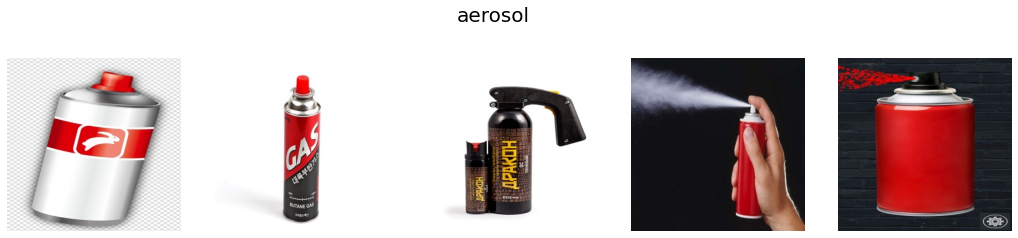

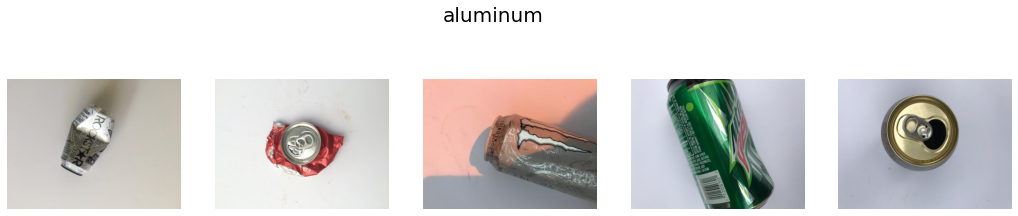

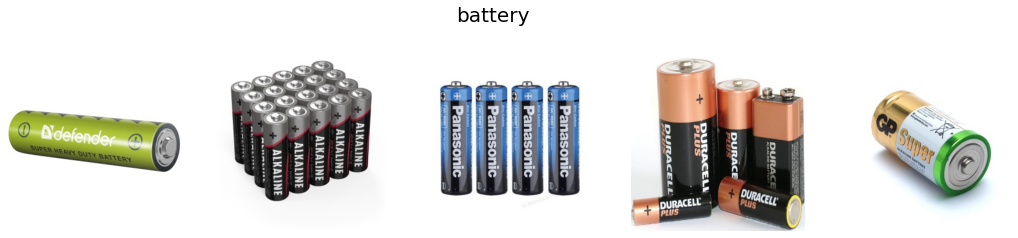

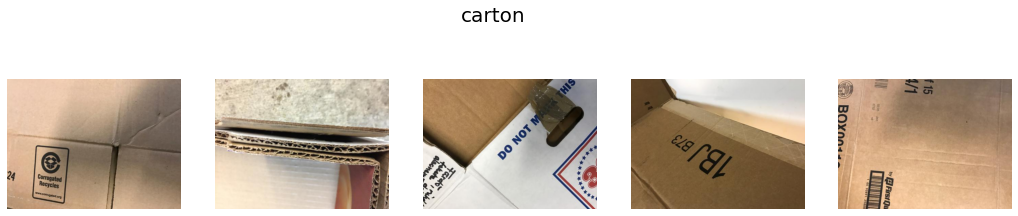

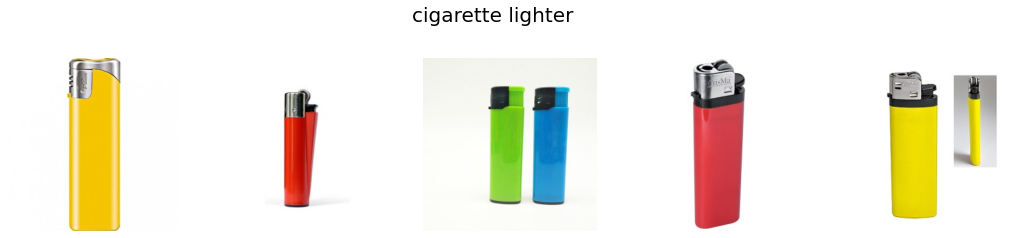

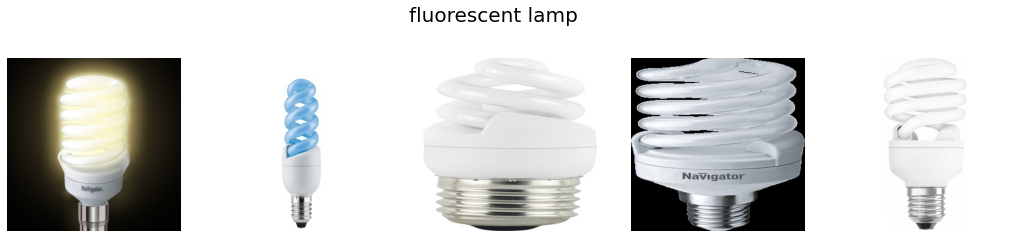

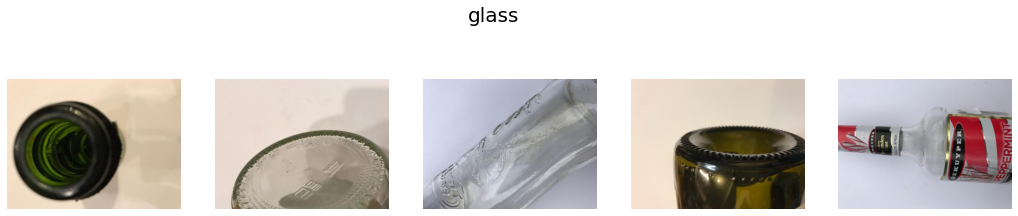

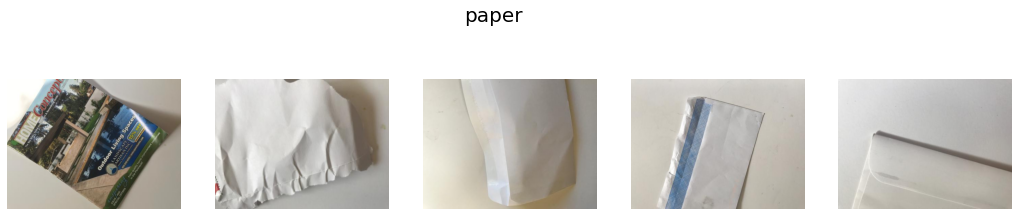

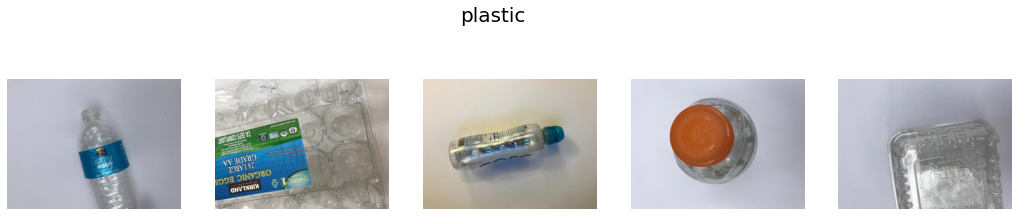

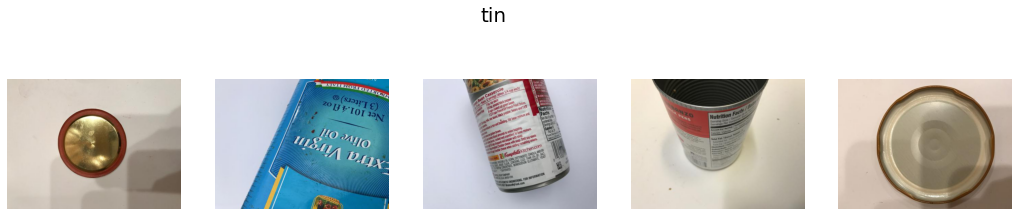

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


def show_images(path, shape, figsize, *, suptitle=None):
    n_rows, n_columns = shape

    file_names = os.listdir(path)

    rng = default_rng()
    random_file_names = rng.choice(file_names, size=(n_rows * n_columns), replace=False)

    fig, axes = plt.subplots(*shape, figsize=figsize)
    axes = axes.flatten()
    for ax, random_file_name in zip(axes, random_file_names):
        random_image = plt.imread(os.path.join(path, random_file_name))
        ax.imshow(random_image)
        ax.set_axis_off()
    fig.suptitle(suptitle, fontsize=20)
    plt.show(fig)


whole_dataset_path = os.path.join(DATASET_PATH, 'whole dataset')
label_names = os.listdir(whole_dataset_path)
sizes = []
for label_name in label_names:
    label_path = os.path.join(whole_dataset_path, label_name)
    
    size = len(os.listdir(label_path))
    sizes.append(size)
    
    show_images(label_path, (1, 5), (18, 4), suptitle=label_name)

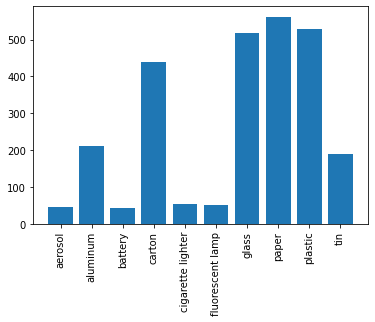

In [4]:
ax = plt.subplot()
ax.bar(label_names, sizes)
ax.set_xticks(label_names)
ax.set_xticklabels(label_names, rotation=90) ;

# GPU connection

In [5]:
from tensorflow.config import list_physical_devices
from tensorflow.config.experimental import (set_memory_growth,
                                            set_visible_devices,
                                            list_logical_devices)


physical_devices = list_physical_devices('GPU')
if physical_devices:
    # Restrict TensorFlow to only use the first GPU
    try:
        # Currently, memory growth needs to be the same across GPUs
        set_memory_growth(physical_devices[0], True)
        
        set_visible_devices(physical_devices[0], 'GPU')
        logical_gpus = list_logical_devices('GPU')
        print(len(physical_devices), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


# Model

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


NUM_CLASSES = len(os.listdir(os.path.join(DATASET_PATH, 'whole dataset')))
BATCH_SIZE = 16
POOL_SIZE = (2, 2)


model = Sequential(
    [
        layers.Conv2D(32, (3, 3), padding='same', input_shape=(300, 300, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=POOL_SIZE),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=POOL_SIZE),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=POOL_SIZE),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ]
)

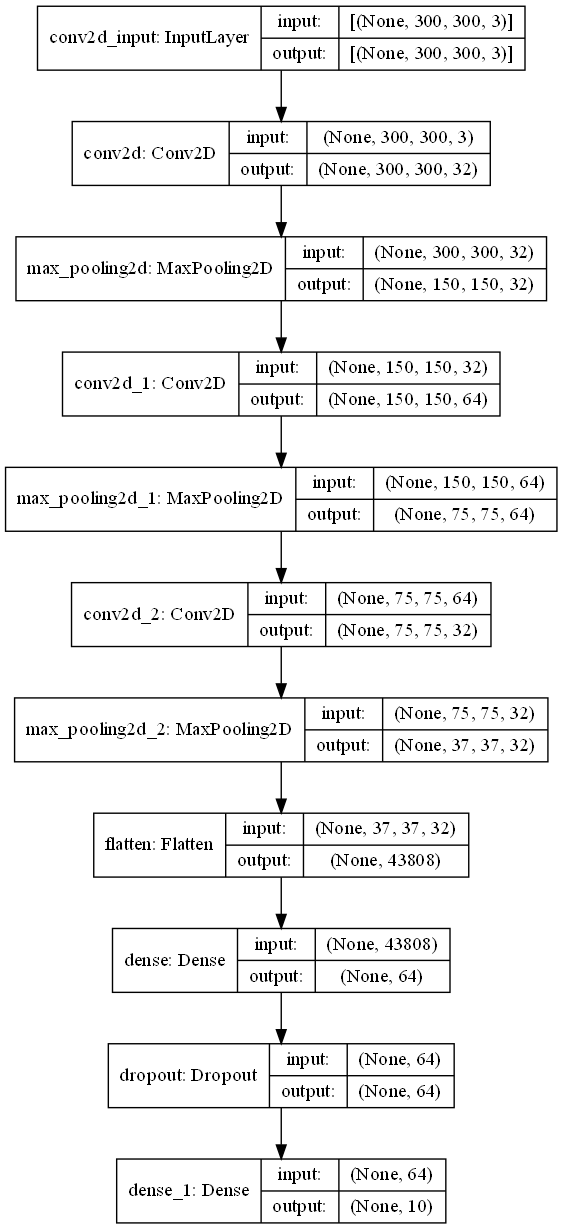

In [7]:
from tensorflow.keras.utils import plot_model


plot_model(model, to_file='model.png', show_shapes=True, rankdir="TB", dpi=100)

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')


train_generator = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen = train_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=(300, 300),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_test_generator = ImageDataGenerator(rescale=1. / 255)
val_datagen = val_test_generator.flow_from_directory(
    VAL_PATH,
    target_size=(300, 300),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_datagen = val_test_generator.flow_from_directory(
    TEST_PATH,
    target_size=(300, 300),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2122 images belonging to 10 classes.
Found 259 images belonging to 10 classes.
Found 259 images belonging to 10 classes.


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint


NUM_EPOCHS = 500
MODEL_PATH = os.path.join(os.getcwd(), 'model.hdf5')


checkpoint = ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)
callbacks_list = [checkpoint]

history = model.fit(train_datagen, epochs=NUM_EPOCHS, callbacks=callbacks_list, validation_data=val_datagen)

Epoch 1/500
133/133 [==============================] - 72s 520ms/step - loss: 2.1372 - accuracy: 0.1951 - val_loss: 1.9910 - val_accuracy: 0.2201

Epoch 00001: val_accuracy improved from -inf to 0.22008, saving model to E:\Projects\Garbage-Classification\model.hdf5
Epoch 2/500
133/133 [==============================] - 52s 390ms/step - loss: 2.0312 - accuracy: 0.1970 - val_loss: 1.8899 - val_accuracy: 0.2317

Epoch 00002: val_accuracy improved from 0.22008 to 0.23166, saving model to E:\Projects\Garbage-Classification\model.hdf5
Epoch 3/500
133/133 [==============================] - 52s 389ms/step - loss: 1.9807 - accuracy: 0.2196 - val_loss: 1.7884 - val_accuracy: 0.3707

Epoch 00003: val_accuracy improved from 0.23166 to 0.37066, saving model to E:\Projects\Garbage-Classification\model.hdf5
Epoch 4/500
133/133 [==============================] - 52s 389ms/step - loss: 1.9171 - accuracy: 0.2418 - val_loss: 1.8181 - val_accuracy: 0.3243

Epoch 00004: val_accuracy did not improve from 0.

133/133 [==============================] - 52s 389ms/step - loss: 1.3569 - accuracy: 0.4892 - val_loss: 1.4899 - val_accuracy: 0.5560

Epoch 00036: val_accuracy improved from 0.54440 to 0.55598, saving model to E:\Projects\Garbage-Classification\model.hdf5
Epoch 37/500
133/133 [==============================] - 52s 388ms/step - loss: 1.3402 - accuracy: 0.5132 - val_loss: 1.4376 - val_accuracy: 0.4826

Epoch 00037: val_accuracy did not improve from 0.55598
Epoch 38/500
133/133 [==============================] - 52s 388ms/step - loss: 1.3077 - accuracy: 0.5198 - val_loss: 1.4753 - val_accuracy: 0.5560

Epoch 00038: val_accuracy did not improve from 0.55598
Epoch 39/500
133/133 [==============================] - 52s 388ms/step - loss: 1.3356 - accuracy: 0.5189 - val_loss: 1.4837 - val_accuracy: 0.5290

Epoch 00039: val_accuracy did not improve from 0.55598
Epoch 40/500
133/133 [==============================] - 52s 388ms/step - loss: 1.3136 - accuracy: 0.5123 - val_loss: 1.5531 - val_accu

133/133 [==============================] - 52s 389ms/step - loss: 1.1331 - accuracy: 0.5872 - val_loss: 1.4288 - val_accuracy: 0.5830

Epoch 00074: val_accuracy did not improve from 0.61776
Epoch 75/500
133/133 [==============================] - 52s 389ms/step - loss: 1.1588 - accuracy: 0.5754 - val_loss: 1.5595 - val_accuracy: 0.5792

Epoch 00075: val_accuracy did not improve from 0.61776
Epoch 76/500
133/133 [==============================] - 52s 388ms/step - loss: 1.1049 - accuracy: 0.5914 - val_loss: 1.7529 - val_accuracy: 0.5985

Epoch 00076: val_accuracy did not improve from 0.61776
Epoch 77/500
133/133 [==============================] - 52s 388ms/step - loss: 1.0906 - accuracy: 0.6013 - val_loss: 2.0334 - val_accuracy: 0.6216

Epoch 00077: val_accuracy improved from 0.61776 to 0.62162, saving model to E:\Projects\Garbage-Classification\model.hdf5
Epoch 78/500
133/133 [==============================] - 52s 389ms/step - loss: 1.1089 - accuracy: 0.5952 - val_loss: 1.9274 - val_accu

133/133 [==============================] - 52s 388ms/step - loss: 0.9862 - accuracy: 0.6395 - val_loss: 1.7218 - val_accuracy: 0.6100

Epoch 00113: val_accuracy did not improve from 0.64479
Epoch 114/500
133/133 [==============================] - 52s 388ms/step - loss: 0.9861 - accuracy: 0.6287 - val_loss: 1.8881 - val_accuracy: 0.6332

Epoch 00114: val_accuracy did not improve from 0.64479
Epoch 115/500
133/133 [==============================] - 52s 389ms/step - loss: 1.0155 - accuracy: 0.6310 - val_loss: 1.3082 - val_accuracy: 0.5985

Epoch 00115: val_accuracy did not improve from 0.64479
Epoch 116/500
133/133 [==============================] - 52s 388ms/step - loss: 0.9971 - accuracy: 0.6291 - val_loss: 1.5297 - val_accuracy: 0.5946

Epoch 00116: val_accuracy did not improve from 0.64479
Epoch 117/500
133/133 [==============================] - 52s 389ms/step - loss: 0.9933 - accuracy: 0.6192 - val_loss: 1.7278 - val_accuracy: 0.6293

Epoch 00117: val_accuracy did not improve from 0.

133/133 [==============================] - 52s 389ms/step - loss: 0.8759 - accuracy: 0.6734 - val_loss: 1.5506 - val_accuracy: 0.6409

Epoch 00153: val_accuracy did not improve from 0.66409
Epoch 154/500
133/133 [==============================] - 52s 389ms/step - loss: 0.8862 - accuracy: 0.6598 - val_loss: 1.8058 - val_accuracy: 0.6486

Epoch 00154: val_accuracy did not improve from 0.66409
Epoch 155/500
133/133 [==============================] - 52s 389ms/step - loss: 0.8751 - accuracy: 0.6720 - val_loss: 2.5625 - val_accuracy: 0.6641

Epoch 00155: val_accuracy did not improve from 0.66409
Epoch 156/500
133/133 [==============================] - 52s 390ms/step - loss: 0.9184 - accuracy: 0.6583 - val_loss: 2.3511 - val_accuracy: 0.6641

Epoch 00156: val_accuracy did not improve from 0.66409
Epoch 157/500
133/133 [==============================] - 52s 389ms/step - loss: 0.9019 - accuracy: 0.6480 - val_loss: 1.3824 - val_accuracy: 0.6564

Epoch 00157: val_accuracy did not improve from 0.


Epoch 00192: val_accuracy did not improve from 0.68726
Epoch 193/500
133/133 [==============================] - 52s 390ms/step - loss: 0.9069 - accuracy: 0.6664 - val_loss: 1.4980 - val_accuracy: 0.6757

Epoch 00193: val_accuracy did not improve from 0.68726
Epoch 194/500
133/133 [==============================] - 52s 389ms/step - loss: 0.8272 - accuracy: 0.6970 - val_loss: 1.7888 - val_accuracy: 0.6216

Epoch 00194: val_accuracy did not improve from 0.68726
Epoch 195/500
133/133 [==============================] - 52s 389ms/step - loss: 0.8935 - accuracy: 0.6772 - val_loss: 1.6761 - val_accuracy: 0.6371

Epoch 00195: val_accuracy did not improve from 0.68726
Epoch 196/500
133/133 [==============================] - 52s 389ms/step - loss: 0.8507 - accuracy: 0.6730 - val_loss: 1.7837 - val_accuracy: 0.6564

Epoch 00196: val_accuracy did not improve from 0.68726
Epoch 197/500
133/133 [==============================] - 52s 390ms/step - loss: 0.8402 - accuracy: 0.6847 - val_loss: 1.4490 - v

133/133 [==============================] - 52s 388ms/step - loss: 0.8142 - accuracy: 0.7059 - val_loss: 1.5092 - val_accuracy: 0.6757

Epoch 00232: val_accuracy did not improve from 0.70270
Epoch 233/500
133/133 [==============================] - 52s 389ms/step - loss: 0.8460 - accuracy: 0.6923 - val_loss: 1.2401 - val_accuracy: 0.6602

Epoch 00233: val_accuracy did not improve from 0.70270
Epoch 234/500
133/133 [==============================] - 52s 389ms/step - loss: 0.7772 - accuracy: 0.7059 - val_loss: 1.4186 - val_accuracy: 0.6680

Epoch 00234: val_accuracy did not improve from 0.70270
Epoch 235/500
133/133 [==============================] - 52s 389ms/step - loss: 0.7626 - accuracy: 0.7121 - val_loss: 1.7658 - val_accuracy: 0.7027

Epoch 00235: val_accuracy did not improve from 0.70270
Epoch 236/500
133/133 [==============================] - 52s 389ms/step - loss: 0.7639 - accuracy: 0.7097 - val_loss: 1.5642 - val_accuracy: 0.6988

Epoch 00236: val_accuracy did not improve from 0.

133/133 [==============================] - 52s 389ms/step - loss: 0.7582 - accuracy: 0.7300 - val_loss: 1.5921 - val_accuracy: 0.6680

Epoch 00272: val_accuracy did not improve from 0.70270
Epoch 273/500
133/133 [==============================] - 52s 388ms/step - loss: 0.6875 - accuracy: 0.7408 - val_loss: 1.7913 - val_accuracy: 0.6795

Epoch 00273: val_accuracy did not improve from 0.70270
Epoch 274/500
133/133 [==============================] - 52s 388ms/step - loss: 0.7534 - accuracy: 0.7177 - val_loss: 1.7673 - val_accuracy: 0.5869

Epoch 00274: val_accuracy did not improve from 0.70270
Epoch 275/500
133/133 [==============================] - 52s 388ms/step - loss: 0.9350 - accuracy: 0.6536 - val_loss: 1.6158 - val_accuracy: 0.6641

Epoch 00275: val_accuracy did not improve from 0.70270
Epoch 276/500
133/133 [==============================] - 52s 388ms/step - loss: 0.7394 - accuracy: 0.7248 - val_loss: 1.6489 - val_accuracy: 0.6795

Epoch 00276: val_accuracy did not improve from 0.

133/133 [==============================] - 52s 389ms/step - loss: 0.7255 - accuracy: 0.7370 - val_loss: 1.4641 - val_accuracy: 0.6950

Epoch 00312: val_accuracy did not improve from 0.71429
Epoch 313/500
133/133 [==============================] - 52s 388ms/step - loss: 0.7111 - accuracy: 0.7521 - val_loss: 1.5057 - val_accuracy: 0.6950

Epoch 00313: val_accuracy did not improve from 0.71429
Epoch 314/500
133/133 [==============================] - 52s 389ms/step - loss: 0.7517 - accuracy: 0.7418 - val_loss: 1.5392 - val_accuracy: 0.7104

Epoch 00314: val_accuracy did not improve from 0.71429
Epoch 315/500
133/133 [==============================] - 52s 389ms/step - loss: 0.6999 - accuracy: 0.7498 - val_loss: 1.4888 - val_accuracy: 0.6988

Epoch 00315: val_accuracy did not improve from 0.71429
Epoch 316/500
133/133 [==============================] - 52s 389ms/step - loss: 0.7164 - accuracy: 0.7309 - val_loss: 1.5496 - val_accuracy: 0.6911

Epoch 00316: val_accuracy did not improve from 0.


Epoch 00351: val_accuracy did not improve from 0.72973
Epoch 352/500
133/133 [==============================] - 52s 388ms/step - loss: 0.6600 - accuracy: 0.7700 - val_loss: 2.1123 - val_accuracy: 0.7066

Epoch 00352: val_accuracy did not improve from 0.72973
Epoch 353/500
133/133 [==============================] - 52s 389ms/step - loss: 0.6808 - accuracy: 0.7498 - val_loss: 1.7534 - val_accuracy: 0.6873

Epoch 00353: val_accuracy did not improve from 0.72973
Epoch 354/500
133/133 [==============================] - 52s 388ms/step - loss: 0.7049 - accuracy: 0.7469 - val_loss: 1.6859 - val_accuracy: 0.6602

Epoch 00354: val_accuracy did not improve from 0.72973
Epoch 355/500
133/133 [==============================] - 52s 389ms/step - loss: 0.7298 - accuracy: 0.7347 - val_loss: 1.7605 - val_accuracy: 0.7027

Epoch 00355: val_accuracy did not improve from 0.72973
Epoch 356/500
133/133 [==============================] - 52s 388ms/step - loss: 0.7369 - accuracy: 0.7234 - val_loss: 1.9540 - v

133/133 [==============================] - 52s 387ms/step - loss: 0.7578 - accuracy: 0.7309 - val_loss: 2.0015 - val_accuracy: 0.6602

Epoch 00391: val_accuracy did not improve from 0.74903
Epoch 392/500
133/133 [==============================] - 52s 388ms/step - loss: 0.7207 - accuracy: 0.7493 - val_loss: 1.9501 - val_accuracy: 0.7027

Epoch 00392: val_accuracy did not improve from 0.74903
Epoch 393/500
133/133 [==============================] - 52s 388ms/step - loss: 0.6717 - accuracy: 0.7573 - val_loss: 2.2806 - val_accuracy: 0.6950

Epoch 00393: val_accuracy did not improve from 0.74903
Epoch 394/500
133/133 [==============================] - 52s 388ms/step - loss: 0.6722 - accuracy: 0.7719 - val_loss: 1.3246 - val_accuracy: 0.7220

Epoch 00394: val_accuracy did not improve from 0.74903
Epoch 395/500
133/133 [==============================] - 52s 388ms/step - loss: 0.6480 - accuracy: 0.7578 - val_loss: 2.2752 - val_accuracy: 0.7181

Epoch 00395: val_accuracy did not improve from 0.

133/133 [==============================] - 52s 388ms/step - loss: 0.5829 - accuracy: 0.7884 - val_loss: 1.8224 - val_accuracy: 0.7336

Epoch 00431: val_accuracy did not improve from 0.76062
Epoch 432/500
133/133 [==============================] - 52s 388ms/step - loss: 0.5994 - accuracy: 0.7856 - val_loss: 2.3198 - val_accuracy: 0.7181

Epoch 00432: val_accuracy did not improve from 0.76062
Epoch 433/500
133/133 [==============================] - 52s 388ms/step - loss: 0.6148 - accuracy: 0.7733 - val_loss: 2.1352 - val_accuracy: 0.7336

Epoch 00433: val_accuracy did not improve from 0.76062
Epoch 434/500
133/133 [==============================] - 52s 389ms/step - loss: 0.6252 - accuracy: 0.7828 - val_loss: 1.9609 - val_accuracy: 0.7181

Epoch 00434: val_accuracy did not improve from 0.76062
Epoch 435/500
133/133 [==============================] - 52s 388ms/step - loss: 0.5973 - accuracy: 0.7799 - val_loss: 1.8899 - val_accuracy: 0.7722

Epoch 00435: val_accuracy improved from 0.76062 t

133/133 [==============================] - 58s 433ms/step - loss: 0.5595 - accuracy: 0.8030 - val_loss: 1.7982 - val_accuracy: 0.7297

Epoch 00471: val_accuracy did not improve from 0.77220
Epoch 472/500
133/133 [==============================] - 58s 438ms/step - loss: 0.5627 - accuracy: 0.8054 - val_loss: 2.3549 - val_accuracy: 0.7143

Epoch 00472: val_accuracy did not improve from 0.77220
Epoch 473/500
133/133 [==============================] - 58s 436ms/step - loss: 0.5959 - accuracy: 0.8016 - val_loss: 3.2646 - val_accuracy: 0.7143

Epoch 00473: val_accuracy did not improve from 0.77220
Epoch 474/500
133/133 [==============================] - 58s 438ms/step - loss: 0.6228 - accuracy: 0.7766 - val_loss: 1.7339 - val_accuracy: 0.7297

Epoch 00474: val_accuracy did not improve from 0.77220
Epoch 475/500
133/133 [==============================] - 58s 436ms/step - loss: 0.5634 - accuracy: 0.8054 - val_loss: 2.3811 - val_accuracy: 0.6950

Epoch 00475: val_accuracy did not improve from 0.

In [11]:
model.evaluate(test_datagen)

17/17 [==============================] - 3s 163ms/step - loss: 0.5336 - accuracy: 0.8726


[0.5336258411407471, 0.8725868463516235]

In [12]:
from tensorflow.keras.models import load_model


h5_model = load_model(MODEL_PATH)
h5_model.evaluate(test_datagen)

17/17 [==============================] - 1s 51ms/step - loss: 0.4801 - accuracy: 0.8649


[0.48008567094802856, 0.8648648858070374]

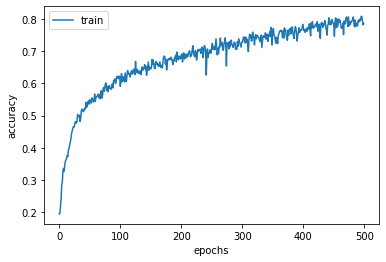

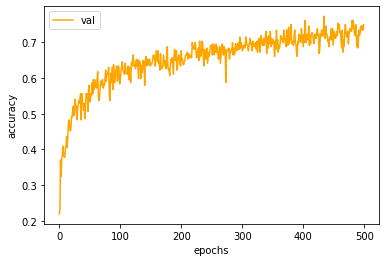

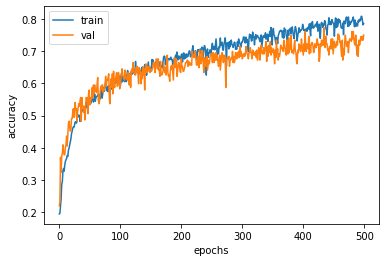

In [13]:
def plot_history(history, mode):
    ax1 = plt.subplot()
    ax1.plot(history.history['%s' % mode])
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('%s' % mode)
    ax1.legend(['train'])
    plt.show()
    
    ax2 = plt.subplot()
    ax2.plot(history.history['val_%s' % mode], color='orange')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('%s' % mode)
    ax2.legend(['val'])
    plt.show()
    
    ax3 = plt.subplot()
    ax3.plot(history.history['%s' % mode])
    ax3.plot(history.history['val_%s' % mode])
    ax3.set_xlabel('epochs')
    ax3.set_ylabel('%s' % mode)
    ax3.legend(['train', 'val'])
    plt.show()


plot_history(history, 'accuracy')

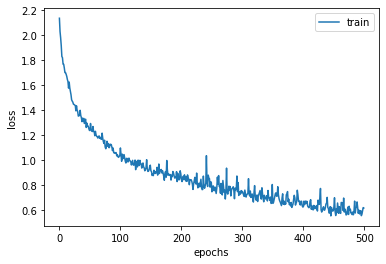

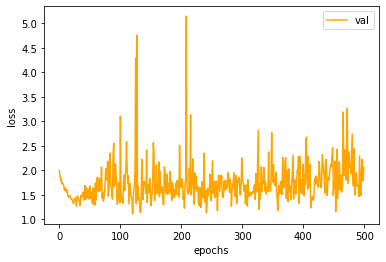

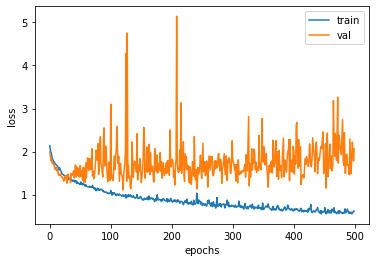

In [14]:
plot_history(history, 'loss')

# Testing

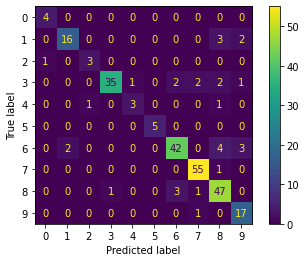

In [15]:
from tensorflow.io import read_file
from tensorflow.io import decode_jpeg
from tensorflow.image import (convert_image_dtype,
                              resize)
from tensorflow import newaxis
from tensorflow import float32

from sklearn.metrics import (confusion_matrix,
                             ConfusionMatrixDisplay)


def load_image(path):
    """Загружет картинку в необходимом формате."""
    raw = read_file(path)
    image = decode_jpeg(raw, channels=3)
    image = convert_image_dtype(image, float32)
    image = image[newaxis]
    image = resize(image, [300, 300])
    return image


def predict_label(model, path, labels):
    image = load_image(path)
    predict = model.predict(image)
    predicted_label = labels[predict[0].argmax()]
    return predicted_label


def get_true_predict_labels(model, path):
    """Возвращает настоящие и предсказанные метки для картинок в директории."""
    true_labels = []
    predict_labels = []
    labels = os.listdir(path)
    
    for dir_name in labels:
        dir_path = os.path.join(path, dir_name)
        file_paths = [os.path.join(dir_path, file_name) for file_name in os.listdir(dir_path)]
        for file_path in file_paths:
            true_labels.append(dir_name)
            
            predicted_label = predict_label(model, file_path, labels)
            predict_labels.append(predicted_label)
    
    return true_labels, predict_labels


true_labels, predict_labels = get_true_predict_labels(model, TEST_PATH)
cm = confusion_matrix(true_labels, predict_labels)
ConfusionMatrixDisplay(cm).plot()